# Explainers Notebook

In [2]:
#imports used for python code
import networkx as nx
from wordcloud import WordCloud
from PIL import Image
from colour import Color
import pandas as pd
import re
import numpy as np
import io
import nltk
import json

%matplotlib inline
from fa2 import ForceAtlas2
import matplotlib
import matplotlib.pyplot as plt
#from community import community_louvain
import random

 ## Motivation 

### What is your dataset?

The data we decided to use for our analysis, contains the Star Wars Movie scripts for all of the episodes (1-8) and the transcripts for the original triology (4-6). In addition to this we have also downloaded all of the Wookiepedia pages for the charcters who are part of the canonical story. This means the characters from the 8 main movies (Episode 1-8), the two stand alone movies (Rogue One and Solo a Star Wars Story) and the two animated series (The Clones Wars and Rebels). This ends up being a total of 408 Wookiepedia articles. The total size of the data is 12.8 MB.
    

### Why did you choose this/these particular dataset(s)?

We decided on using these two datasets because they hold all the information we need to get out the information we want. The transcript we choose as they hold all the information given in the movies, which is what most casual Star Wars fans only has knowledge of. These are good for analysing sentiments and other stuff.
However, it is very difficult to get any sort of relation between the characters out of the scripts therefore we decided to also download the Wookiepedia articles, as these through the use of hyperlinks will tell us how the characters are connected, according to the fans writing these articles. Also from the Wookiepedia articles we also get some extra data about characters such as race and affiliations, which might not be available through the transcripts.
    
### What was your goal for the end user's experience?

The goal of the project to get a insight to the universe which might not be obvious to the average fan, through analyzing communities, sentiments and nodedegrees. Hopefully we will be able to get some knowledge which will enlighten and educate the user in how the universe is actually working.

## The Dataset
 
### Data cleaning and preprocessing

As our data consist of two sets, we will first explain how we got and preprocessed the movie transcripts, and afterwards for the Wookiepedia articles.

The movietranscripts and dialogue come from multiple sources, [IMSDb](https://www.imsdb.com), [Kaggle](https://www.kaggle.com/xvivancos/analyzing-star-wars-movie-scripts/data) and the [Transcripts wiki](http://transcripts.wikia.com/wiki/Transcripts_Wiki). This is due to neither of the two having all of the necessary data at the time of writing. 

The dialogues is available for episode IV, V and VI and is stored in .txt with the index of line, the speaker and the dialogue itself. As preprocessing we used regular expressions '''"(.*)" "(.*)" "(.*)"''' to load the lines into a dict, using the charactername as key and their lines in a list as value. Furthermore, we had to manually assess the characternames, as some characters was noted with multiple names throughout the dialogue and typos in the source material was present. The scripts from IMSDB we first downloaded as HTML files, and then removed all of the HTML code to only get the script text. This was done using regular expressions. The scripts we found on the transcripts wiki, has been downloaded as other wiki data through the use of an API. The scriptdata have not been through further prepocessing before usage.

For the Wookieepedia pages we first had to get a list of all the canonical characters. Unfortunately Wookieepedia does not have such a list, and we had to find it on the Wikipedia page for [List of Star Wars characters](https://en.wikipedia.org/wiki/List_of_Star_Wars_characters). This however posed a few unexpected challenges. First of all we downloaded the page through the use of the wikipedia API. Most of the characters names was the written in a set of brackets like {{visible anchor | name}}. This made it fairly easy to the names by using some regular expressions. However not all of the names in the list are the same as the names used on Wookieepedia. This meant we had to remove titles such as Admiral, or only use the first or last name of a character. This however resulted in us getting too many names, as some of the last names of characters, like (Jabba the) Hutt, is the name of a species and therefore has its own Wookieepedia page. These we ended up removing manually. The last hurdle when working with the Wikipedia page, was that two character names did not follow the earlier mentioned structure, meaning we had to add these manually as well. These two where Anakin Skywalker and Darth Sidious, which are rather important for the network. In the end we ended up with 407 names, which have all been saved in a CSV file for convinence. 

In addition to the names we also add the race of the characters and their "goodness" in the CSV file. The race was found on the Wookieepedia page, and the goodness score is calculated on a scale based on which affiliations the characters have on their pages. An evil affiliation will count as -1 and a good affiliation counts as +1. Affiliations being good or evil is based on whether they are connected to the Sith (evil) or the Jedi(good). (Again should we add the preprocessing code here???)


### Dataset stats

So in total we ended up with a CSV file containing 407 rows and four columns (Name, Wookieepedia link, Race and Goodness), 407 Wookiepedia articles and 8 movies transcripts. This totaled up to 12.8 MB of data. 

 ## Tools, theory and analysis
 
     Talk about how you've worked with text, including regular expressions, unicode, etc.
 
     Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
     
    How did you use the tools to understand your dataset?

 
### Overall idea
 
We want to create a network over the characters and their connections. This graph will contain the character names as nodes and the edges between them will be the hyperlinks from the Wookieepedia articles. Where an edge from one node to another means that that characters links to the other. From the network we wish to analyze the centrality measures to get an idea of which characters are important. We also want to find communities in the network and see how these fit up with the known alliances, races or movies. In addition to this we also wish to use the Wookieepedia articles to make a sentiment analysis to see if there is a race which we can consider to be more happy than the others, and which is the most negative.

The movie transcript will be used for sentiment analysis, to try to see if we can detect certain scenes in the movies and see how the mood changes over a single movie or all of the movies. We also wish to see how the mood for individual characters change over a single movie or multiple movies.  
 

 

### Analysis step 1 : The Network
 
#### Explain what you're interested in
     
Interested in creating a network over the characters, to analyze connections to see who is the most important person, analyze communities to see if these follow any grouping of the actual connection such as race, movie, alliance, family or other. And we wish to find which race is the most happy, based on the content of the Wookiepeedia artclies for the characters of each race.

To create the network we will create a directed graph, where we will first create a node for each of the characters from our CSV file. As attributes each node will get their race and goodness. Then we will load each file one by one and add an edge from a node to another node if the corresponding Wookieepedia file from the first node contains a hyperlink to the other node. The way we get the links is by using regular expressions as all of the links are trapped between two set of square brackets, with the link match the name of the character. 

We will then draw the graph using the ForceAtlas library, with the nodes sizes according to their degree, and colored accoring to their goodness score from evil (red) to good (green).


In [ ]:
# Loading in the character data
df = pd.read_csv('starwarscharacters.csv')

# Creating the directed graph for the network
G = nx.DiGraph()

# Adding the nodes
for i in range(len(df)):
    name = df.loc[i]['name']
    species = df.loc[i]['species']
    goodness = df.loc[i]['goodness']
    G.add_node(name, goodness=goodness, species=species)
    
# Adding the edges
for i in range(len(df)):
    name = df.loc[i]['name']
    
    # Loading the Wookieepedia text
    fileName = name.replace(" ", "_") + ".txt"
    text = open("./Wookiepediafiles/" + fileName, "r").read()
    
    # Finding the links in the Wookieepedia article and adding them as edges
    links = re.findall('\[\[(.*?)\]\]', text)
    for link in links:
        for l in link.split("|"):
            if l in list(df['name']):
                if not G.has_edge(name, l):
                    G.add_edge(name, l)
                break

                

In [ ]:
# Set up forceatlas2 parameters
G_undir = G.to_undirected()

forceatlas2 = ForceAtlas2(# Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,
                          adjustSizes=False,
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=False,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=1.0,
                          strongGravityMode=False,
                          gravity=100.0,
                          # Log
                          verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G_undir, pos=None, iterations=10000)

In [ ]:
# Drawing the graph
plt.figure(figsize=(20,12))
plt.title("Node size scaled by degree")


# Creating the colorscale according to goodness
red = 255
green = 0
stepSize = 64 
colorScale = []
while green < 255 :
    green += stepSize
    if green > 255 : 
        green = 255
    colorScale.append(('#%02x%02x%02x' % (red, green, 0)))

while(red > 0) :
    red -= stepSize
    if red < 0 :
        red = 0
    colorScale.append(('#%02x%02x%02x' % (red, green, 0)))

# Setting up datastructure used for the drawing    
sizemap_degree = []    
colormap = []
for node in G_undir:
    sizemap_degree.append(G.degree(node, weight="weight") + 2)
    idx = G.node[node]['goodness']+3
    colormap.append(colorScale[idx])

nodelist = [node for node in G_undir.nodes]
edgelist = [edge for edge in G_undir.edges]

# Adding labels for the most important characters
labelNodes = ["Anakin Skywalker", "Obi-Wan Kenobi", "R2-D2", "C-3PO", "Darth Sidious", "Luke Skywalker", "Han Solo"]
labels = {}
for node in nodelist :
    if node in labelNodes :
        labels[node] = node
    else :
        labels[node] = ""

# Drawing the nodes, edges and selected labels
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist, node_color=colormap, edgecolors="black", node_size=sizemap_degree)
nx.draw_networkx_edges(G_undir, positions, alpha=0.2, edge_color="black", width=0.5, edgelist=edgelist)
nx.draw_networkx_labels(G_undir,pos=positions, labels = labels, font_color = "black", font_weight = "bold")
plt.show()

### Analysis step 1.1 : Centrality measurements
 
#### Explain what you're interested in
We're interested in measuring the centrality of all of the Star wars characters, in order to get an idea of the most important characters. We will do this using three different centrality measures: Degree centrality, betweenness centrality and eigenvector centrality.
 
#### Explain the tool
_Degree centrality_ is nice

_Betweenness centrality_ also nice

_Eigenvector centrality_ most nice

#### Apply the tool
 
#### Discuss the outcome

### Analysis step 1.2 : Community detection
 
#### Explain what you're interested in
For this step we wish to analyze our network to see if we can find any communities. And if so how to fit with the actual affiliations between the characters such as family, race, movie or alliance. Or see if we find some communities which are not obvious from the movies.
 
#### Explain the tool
For this we will be using the Louvain algorithm to find the communities. The way this algorithm works is by trying to maximize the modularity, which is a measurement of how many links are between the nodes in the community compare to between the different communities. We are going to use the built-in algorithm from the community library.
 
#### Apply the tool

In [ ]:
# Applying the algorithm
partition = community_louvain.best_partition(G_undir)
print("Value of modularity: %s" % community_louvain.modularity(partition, G_undir))

# Extracting the communities to separate lists
communities = []
for com in set(partition.values()):
    list_nodes = [node for node in partition.keys()
                                if partition[node] == com]
    if len(list_nodes) > 1:
        communities.append(list_nodes)
        
# Sort the communities based on nodedegree    
comDegrees = []
for com in communities :
    comDegreeSorted = sorted(com, key=lambda x: G.degree(x), reverse=True)
    comDegrees.append(comDegreeSorted)  
    
# Set colors for communities
rColors = []
rColors.append("#007FFF")
rColors.append("#C19A6B")
rColors.append("#FFBF00")
rColors.append("#FDEE00")
rColors.append("#FF0000")
rColors.append("#C5E17A")
rColors.append("#000000")
rColors.append("#00CCCC")
rColors.append("#000000")
rColors.append("#000000")
rColors.append("#000000")
rColors.append("#000000")
rColors.append("#000000")
rColors.append("#000000")

# Create colormap for graph
colormap = []
for node in G_undir:
    for i in range(len(communities)):
        com = communities[i]
        if node in com:
            colormap.append(rColors[i])
            break
            
# Draw the network
plt.figure(1, figsize=(16, 12)) 
light_gray = '#d3d3d3'
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist, node_color=colormap, edgecolors="black", node_size=sizemap_degree)
nx.draw_networkx_edges(G_undir, positions, alpha=0.2, edge_color="black", width=0.5, edgelist=edgelist)

plt.show()

#### Discuss the outcome
We get that the modularity is 0.37

In [ ]:
for com in comDegrees :
    print com[:15]

From the communities we can see that they have been clustered into some general groups. The first community containing characters like Ahsoka Tano, Dooku, Padmé Amidala, Mace Windu, Qui-Gon Jinn and Grievous. These are all characters who are only part of the Episodes 1-3 and The Clone Wars animated series, which is what seems to be captured by this community. It however also contains characters like Darth Sidious and Obi-Wan Kenobi, which are also part of the Episodes 4-6, which is part of the reason why the modularity is not too big.

The second community contains characters like Anakin, Jabba, Boba Fett, Bossk and Sebulba. What seems to be in common here is the connections to the planet of Tatooine, which is where Jabba has his gangster empire and Anakin and Sebulba are native too.

The third has characters like Ezra, Kana, Hera and C1-10P which are all from the animated series Star Wars Rebels.

The fourth community consist of characters like Leia, Han, Luke and Chewbacca, but also Poe, Kylo and Rey. So what seems to be caugth by this community is the Episodes 4-8, which make alot of sense since most of the cast from 4-6 also play a part in episode 7 and 8.

The next community contains characters like Jyn Erso, Galen Erso, Cassian Andor, K-2SO and Chirrut which are part of the main cast of the Rogue One movie.

For the sixth community we have R2-D2, C-3PO, Owen Lars, Shmi Skywalker, Beru Lars and Cliegg Lars. This is a bit more difficult to match as most of these are in family, and local to Tatooine, but then we have the two droid, which only have a weak connection to these.

The last communities seems to capture some famlies. The Naberries and Panzoro, and in the last The Smuggler and Riley are brother and sister, which are hires by Dapp according to Wookiepedia.

We see that it seems the community detection algorithm mostly found the communities based on which movies or family they belong to. This also seems to be the reason for the lower modularity as many of the characters span across alot of movies and therefore will have a lot of edges to other characters in other communities.

### Analysis step 1.3 : Race sentiment analysis
 
#### Explain what you're interested in
 
#### Explain the tool
 
#### Apply the tool
 
#### Discuss the outcome

### Preprocessing step 2:

In [3]:
# Regular expression returning the tuple (index, character, dialogue) for each line
def getInfo(str_in):
    grouped = re.findall('"(.*)" "(.*)" "(.*)"', str_in)
    if len(grouped) == 0:
        return None
    return grouped[0]

# For each line in the dialogue, add the line to the characther dict
def getCharacterDictFromFile(file_name):
    df = pd.read_fwf(file_name)
    lines = []
    for i in df['"character" "dialogue"']:
        lines.append(getInfo(i))
    character_dict = {}
    for line in lines:
        if line is None:
            continue
        if line[1] in character_dict:
            character_dict[line[1]].append(line)
        else :
            character_dict[line[1]] = [line]
    return character_dict

character_dictIV = getCharacterDictFromFile('./Transcripts/SW_EpisodeIV.txt')
character_dictV = getCharacterDictFromFile('./Transcripts/SW_EpisodeV.txt')
character_dictVI = getCharacterDictFromFile('./Transcripts/SW_EpisodeVI.txt')

### Analysis step 2 : The Transcripts - talking distribution and wordclouds
 
#### Explain what you're interested in
We find it interesting to look into the dialog of the original movies. We wish to investigate which characters are the most talkative, and what words are the most "saying" for the different movies.
 
#### Explain the tool
In order to find the most talkative character from the triology, we perform a simple count for every character in the dialogue_dict that was generated for every movie through the preprocessing.   

In the generation of the individual movie-wordclouds we build upon TF-IDF as defined below: 
\\[ tf(t,d) = \dfrac{f_{t, d}}{\mid d_u \mid} \qquad f_{t,d} = \text{the frequency of t in d} \qquad d_u = \text{Unique words in d} \\  idf(term, documents) = \log \left( \dfrac{N}{\mid \left\{ document \in documents : term \in document \right\} \mid}  \right) \\
tfidf(t, d, D) = tf(t, d) \cdot idf(t, D) \\]
Before inputting our data into the TF-IDF, we removed punctionation and stopwords and words with length <= 1. 
 
#### Apply the tool

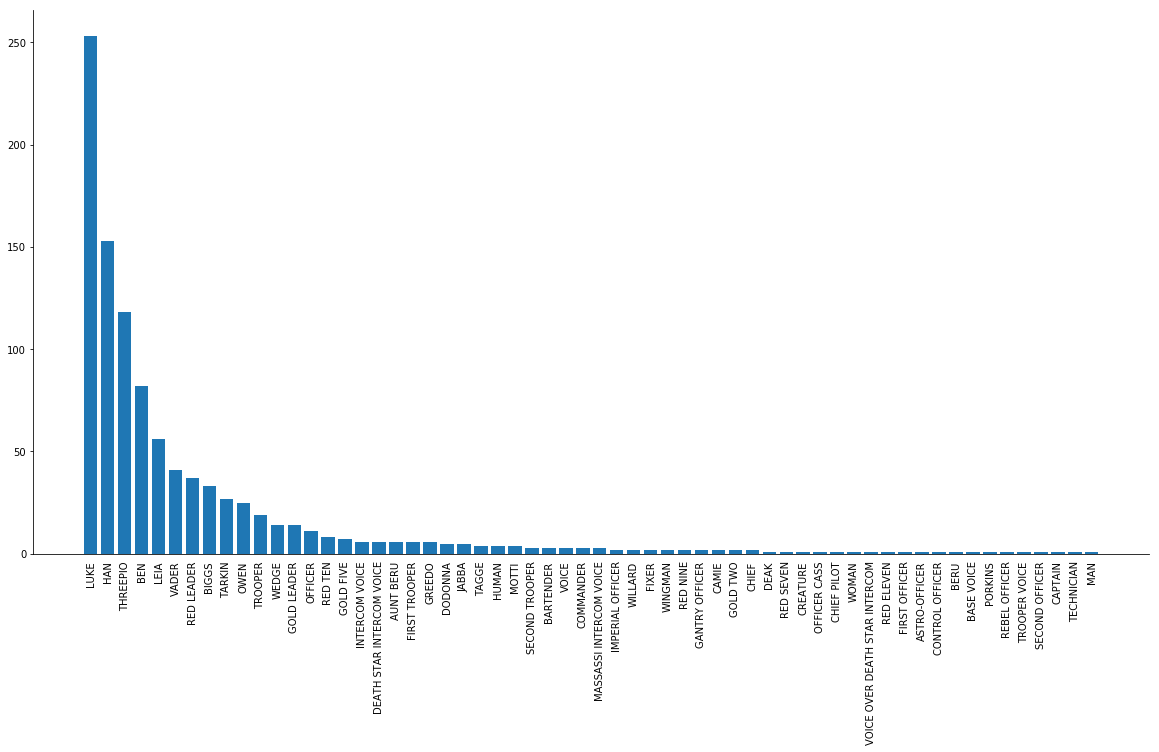

In [4]:
# Generating a sorted list of characters and how much they talk.
def getCharacterTalk(character_dict):
    character_talk = {}
    for character in character_dict:
        character_talk[character] = len(character_dict[character])
    sorted_character_talk = sorted (character_talk.items(), key=lambda x: x[1], reverse=True)
    return sorted_character_talk

# Generating the list for the three movies
character_talkIV = getCharacterTalk(character_dictIV)    
character_talkV = getCharacterTalk(character_dictV)    
character_talkVI = getCharacterTalk(character_dictVI)    

# Plotting the sorted number of lines for each character in a bar-plot, enabling us to quickly spot the result. 
# The image is then saved to a folder to make it easy for us to update the webpage.
def drawTalkPlot(talk, name):
    x = []
    y = []
    for i in talk:
        x.append(i[0])
        y.append(i[1])

    plt.figure(figsize = (20,10))
    plt.title("")
    plt.bar(x,y)
    plt.xticks(rotation=90)
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    plt.rcParams.update({'figure.autolayout': True})
    plt.rcParams.update({'font.size': 12})
    plt.savefig("docs/img/"+name+".png", transparent=True)
    plt.show()

# Executing the method, actually generating the plots and saving them to files for easy update of the 
drawTalkPlot(character_talkIV, "talk_alot_iv")
#drawTalkPlot(character_talkV, "talk_alot_v")
#drawTalkPlot(character_talkVI, "talk_alot_vi")

We then move on to the wordcloud generation:

C:\Users\s153746\AppData\Local\Continuum\anaconda3\envs\py27\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


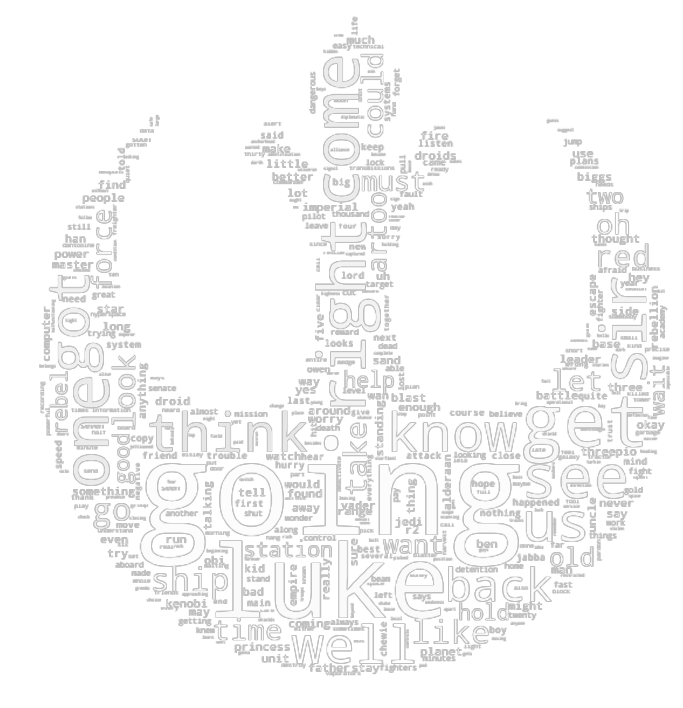

In [5]:
def tokenize(text):
    text = text.encode('ascii','ignore')

    # Remove all punctuation and numbers
    regexp = '[^\W]+'
    cleanTokens = re.findall(regexp, text)
    
    # Remove all words of length 1 and set lowercase
    cleanTokens = [w.lower() for w in cleanTokens if len(w) > 1]
    stopwords = nltk.corpus.stopwords.words('english')

    # Remove stopwords
    cleanTokens = [w for w in cleanTokens if w not in stopwords]
    
    return cleanTokens

# Returning a oneliner for a given dialogue_dict. Simply a oneliner of all dialogue in the movie.
def oneLiner(character_dict):
    one_list_to_rule_them_all = []
    for char in character_dict:
        for line in character_dict[char]:
            one_list_to_rule_them_all.append(line[2])
    return " ".join(one_list_to_rule_them_all)

def tf_idf(doc1, docs):
    # TF
    fd = nltk.FreqDist(doc1) # We utilize the nltk to easily get the frequency of 
    sorted_tokens = [x[0] for x in fd.most_common()]
    tf = np.array([(float(x[1]) / len(fd)) for x in fd.most_common()])


    # IDF
    dem_sets = [set(doc1)]
    for doc in docs:
        dem_sets.append(set(doc))
       
    df = np.array([sum([t in s for s in dem_sets]) for t in sorted_tokens])    
    idf = np.log((len(docs)+1) / df)
    
    tf_dict = {}
    for i in range(len(sorted_tokens)):
        tf_dict[sorted_tokens[i]] = tf[i] * idf[i]
    return tf_dict

# Grey colors, used as the colorfunction in our wordcloud in order to ensure that the words are visible on colorful backgrounds.
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(90, 100)

def generate_wordcloud(doc, docs, name):
    doc_tokens = tokenize(doc)
    docs_tokens = tokenize(" ".join(docs))
    tfidf = tf_idf(doc_tokens, docs_tokens)
    
    r2_mask = np.array(Image.open('./Transcripts/rebel.png', 'r'))
    wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA" ,max_words=2000, mask=r2_mask)

    wordcloud.generate_from_frequencies(tfidf)
    
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3), interpolation="bilinear")
    plt.axis("off")
    
    plt.rcParams.update({'figure.autolayout': True})
    plt.savefig("docs/img/"+name+".png", transparent=True)

    plt.show()
    
textIV = oneLiner(character_dictIV)
textV = oneLiner(character_dictV)
textVI = oneLiner(character_dictVI)

generate_wordcloud(textIV, [ textV, textVI], "word_cloud_iv")
#generate_wordcloud(textV, [textIV, textVI], "word_cloud_v")
#generate_wordcloud(textVI, [textIV, textV], "word_cloud_vi")

#### Discuss the outcome
From our results we see that C3PO talks a surprising amount when comparing him to the other character of the series. Especially it is interesting that he talks so much more than the charachters we first think of when we talk about Star Wars (Luke, Han, Vader).

From the wordclouds we also run into surprises, we did not expect to meet going as one of the most "siginificant" *WE NEEED A BETTER WORD* words. When looking into the dialogue we however see that going is mentioned 62 times in Star Wars Episode 4, but only 41 in episode 5 and 6 combined, the words is as shown by the wordcloud overrepresented by "A New Hope". Furthermore, we see that names are also heavily represented, showing that the dialogue indicates who the important characters are.

### Analysis step 2.1 : Sentiment for dialogue (+ scripts)
 
#### Explain what you're interested in
As mentioned above, we find it interesting to look into the dialogue of the original triology. We want to further investigate the sentiment of the dialogue. 
* Can we see an evolution throughout the series in certain characters? Does the sentiment of Darth Vader show that he is turning to the light?
* Can we spot scenes from the sentiment alone?
* Can we from the sentiment guess if a character is "good" or "evil"?
    * What the character says
    * When the character is mentioned
 
#### Explain the tool
To investigate this, we look into the use of sentiment though sentiment lists (to be shown below) and tokenization as shown above. We utilize the same preprocessed data in our quest for information (and spoilers).

#### Apply the tool

In [36]:
def read_file(filename):
    with io.open('./'+filename, encoding='utf-8') as f:
        return f.read()

# Read word list and extract all the various categories
mt_word_list = read_file('Sentiment_Data_Set_S1.txt').splitlines()[3:]
sentiment_dict = {}

# Iterating over every word in the sentiment file and store it in a dictionary with word as key and sentiment as value
for row in mt_word_list[1:]:
    cols = row.split("\t")
    word = cols[0]
    # cols[2] is the happiness score avg.
    sentiment_dict[word] = cols[2]

def get_sentiment(tokens):
    #sentiment_sum = 0.0
    #count = 0
    sentiments = [] 
    for token in tokens:
        if token in sentiment_dict:
            sentiments.append(float(sentiment_dict[token]))
            #sentiment_sum += float(sentiment_dict[token]) # happiness avg
            #count += 1
    #if count == 0:
    #    return None
    #avg_hap = sentiment_sum / float(count)
    return np.mean(sentiments)

# Given a characther and the character_dict(dialogue), we can return a list of indexed of when the characther spoke, 
# as well as the lines he spoke. We can then get sentiment for the individual sentances and get an idea of the "moment"
def getSentimentsForCharacter(character, character_dict):
    time = []
    sentiments = []
    if character not in character_dict:
        return None
    c = character_dict[character]
    for line in c:
        tokens = tokenize(line[2])
        sentiment = get_sentiment(tokens)
        if(sentiment) is None:
            continue
        time.append(int(line[0]))
        sentiments.append(sentiment)
    return time, sentiments

C:\Users\s153746\AppData\Local\Continuum\anaconda3\envs\py27\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\s153746\AppData\Local\Continuum\anaconda3\envs\py27\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\s153746\AppData\Local\Continuum\anaconda3\envs\py27\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\s153746\AppData\Local\Continuum\anaconda3\envs\py27\lib\site-packages\matplotlib\cbook\__init__.py:1874: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\s153746\AppData\Local\Continuum\anaconda3\envs\py27\lib\site-packages\matplotlib\cbook\__init__.py:1881: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
C:\Users\s

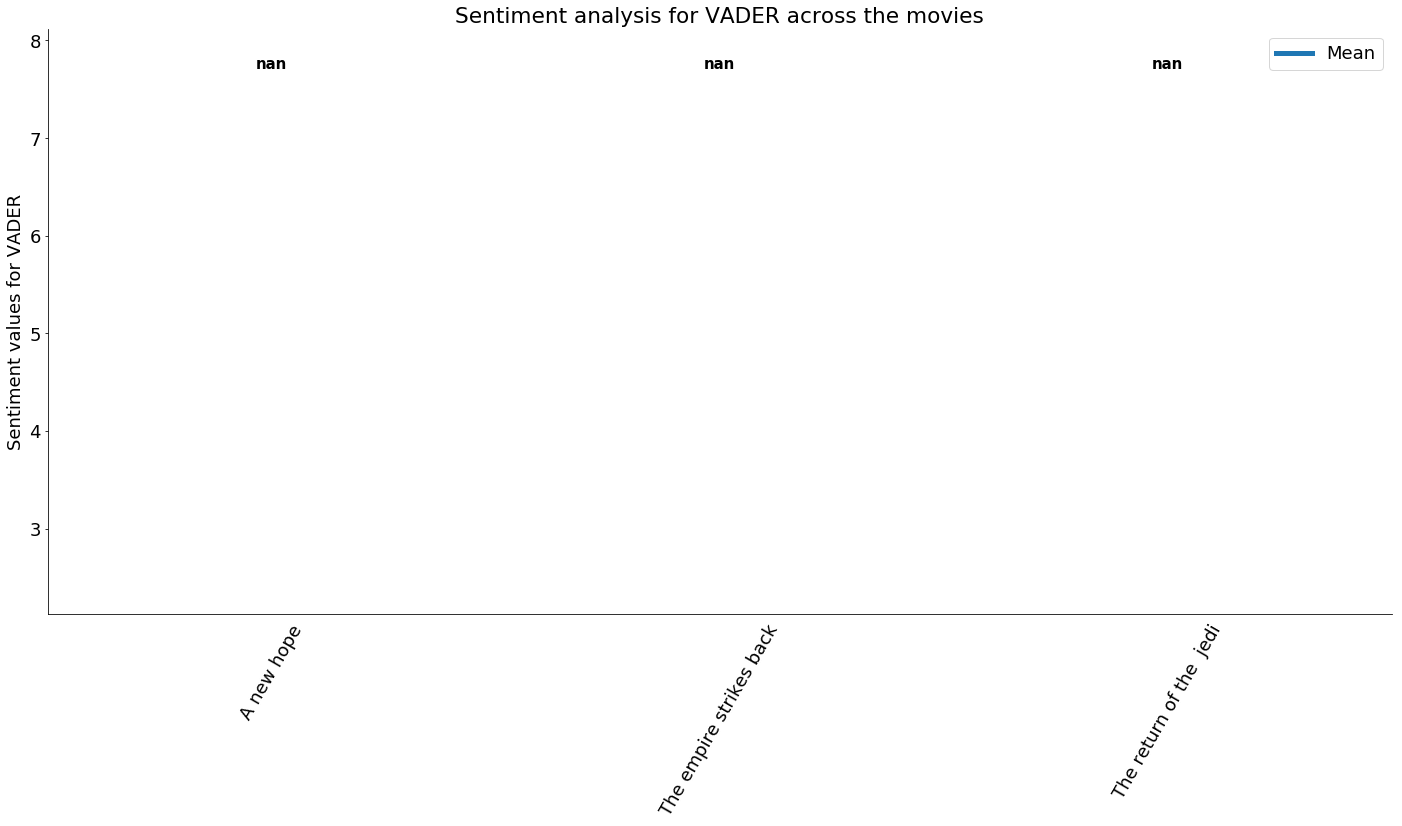

In [37]:
def characterSentimentAcrossMovies(char, list_of_dicts, movie_names, name):
    fig, ax1 = plt.subplots(figsize=(20, 12))
    ax1.set_axisbelow(True)
    ax1.set_title("Sentiment analysis for " + char + " across the movies")
    ax1.set_ylabel("Sentiment values for "+ char)
    
    top = 0
    bottom = 100
    data = [] 
    for char_dict in list_of_dicts:
        d = getSentimentsForCharacter(char, char_dict)[1]
        if top < max(d):
            top = max(d)
        if bottom > min(d):
            bottom = min(d)
        data.append(d)
    bp = ax1.boxplot(data)
    ax1.set_xticklabels(movie_names, rotation=60)
    
    plt.setp(bp['medians'], color="black")
    plt.setp(bp['medians'], linewidth=2.5)
        
    top = top + 1
    bottom = bottom - 0.25
    ax1.set_ylim(bottom, top)
    
    medians = [np.median(a) for a in data]
    pos = np.arange(len(list_of_dicts)) + 1
    upperLabels = [str(np.round(s, 2)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(len(list_of_dicts)), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
                 horizontalalignment='center', size='small', weight="bold",
                 color="black")
        
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    
    d1 = [i+1 for i in range(len(list_of_dicts))]
    d2 = [np.mean(a) for a in data]
    plt.plot(d1, d2, linewidth= 5, label="Mean", color="#1f77b4")  
    plt.legend()
    plt.rcParams.update({'font.size': 24})
    plt.rcParams.update({'figure.autolayout': True})
    plt.savefig("docs/img/"+name+".png", transparent=True)

    plt.show()  
characterSentimentAcrossMovies("VADER", [character_dictIV, character_dictV, character_dictVI], ["A new hope", "The empire strikes back", "The return of the  jedi"], "VADER_sentiment")

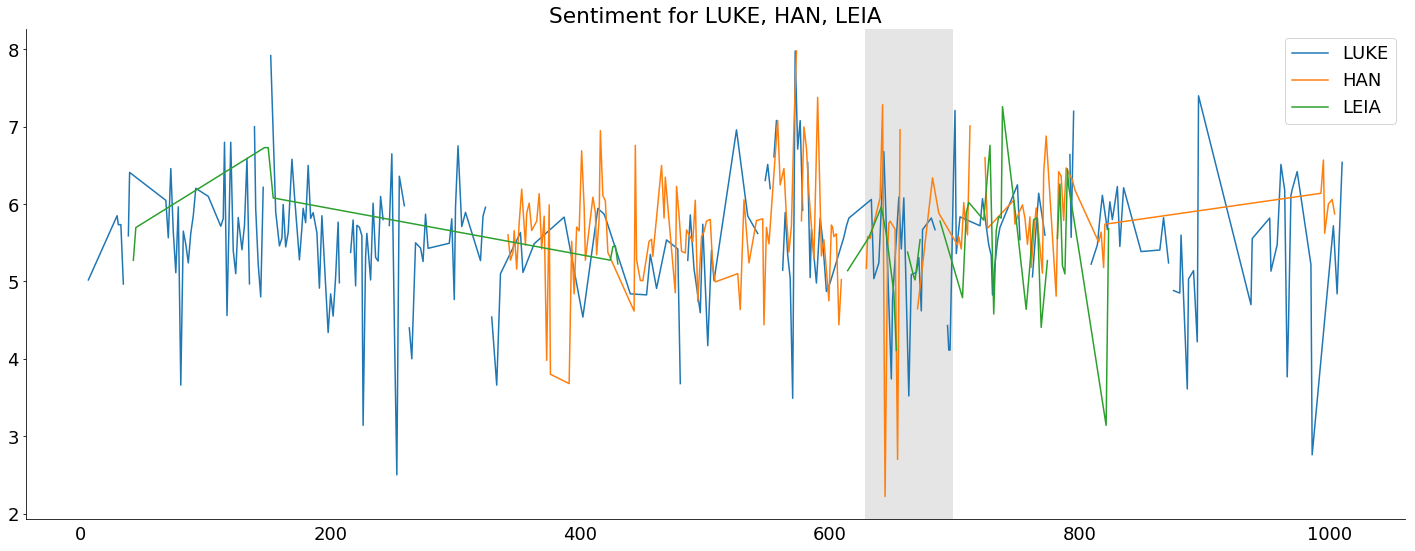

In [39]:
def drawSentimentForCharacters(chars, character_dict):
    plt.figure(figsize=(20,8))
    plt.title("Sentiment for " + ", ".join(chars))
    for char in chars:
        x, y = getSentimentsForCharacter(char, character_dict);
        plt.plot(x,y)
    plt.axvspan(628, 698, facecolor='0.5', alpha=0.2)
    plt.legend(chars)
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    
    plt.rcParams.update({'font.size': 18})
    plt.show()
drawSentimentForCharacters(["LUKE", "HAN", "LEIA"], character_dictIV)

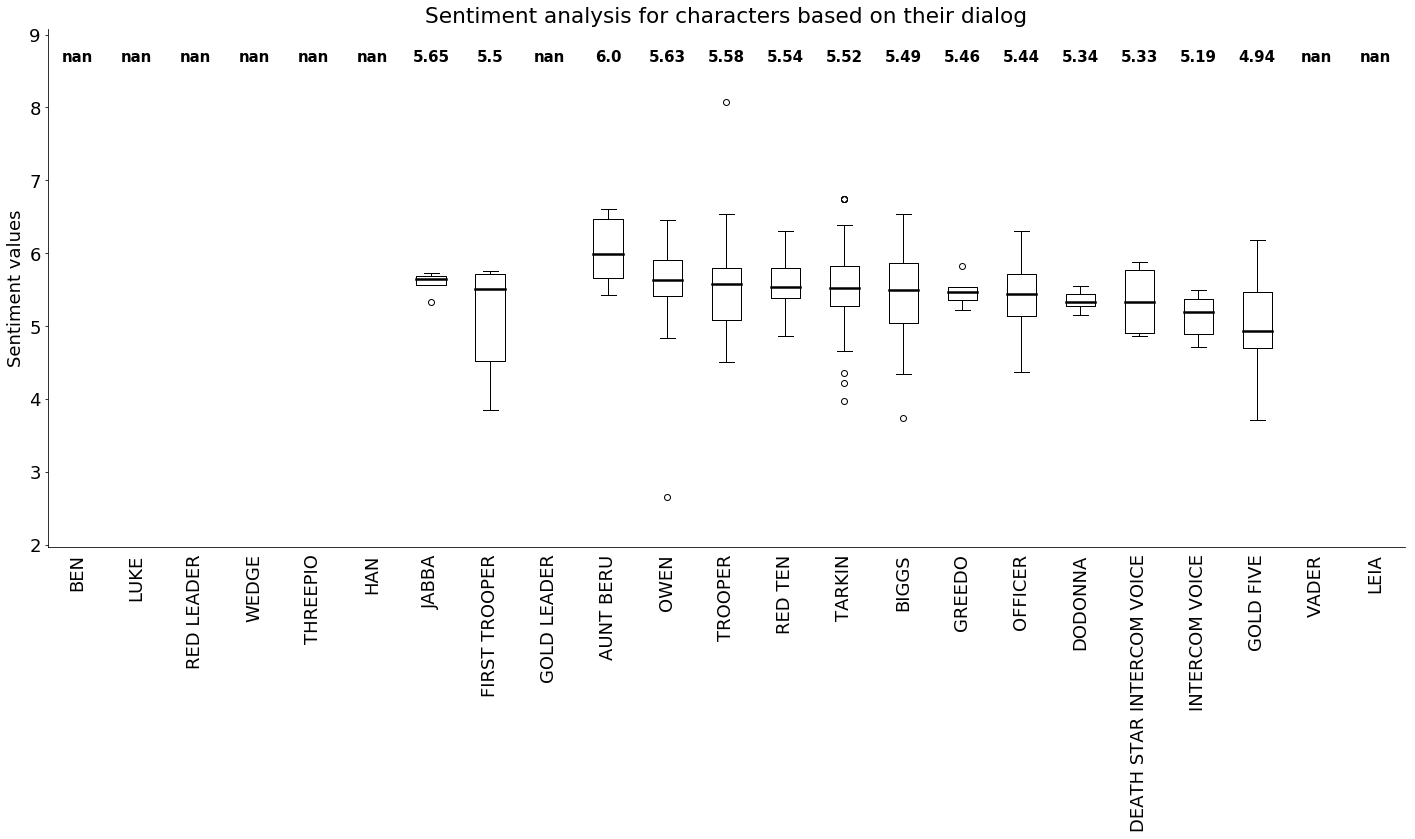

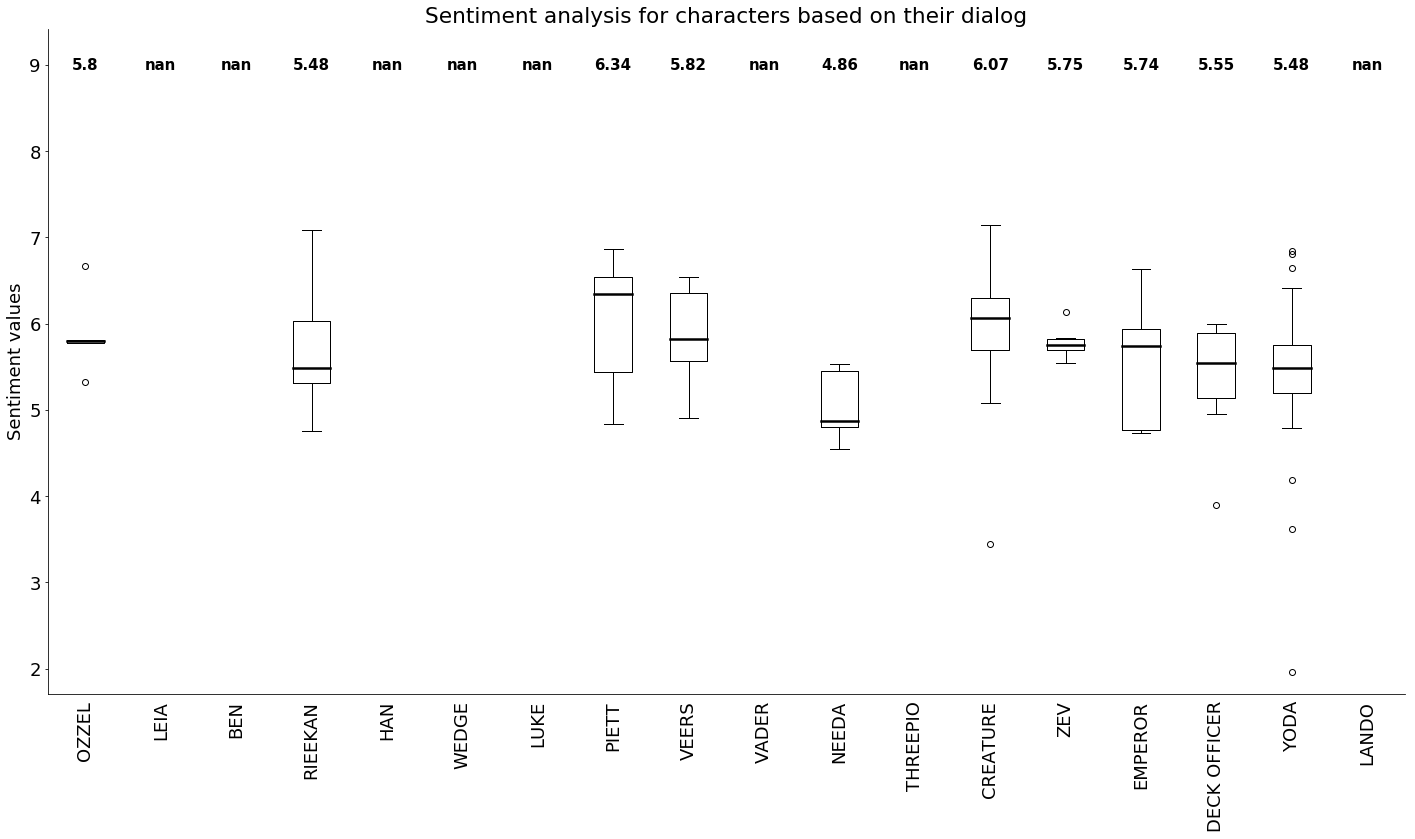

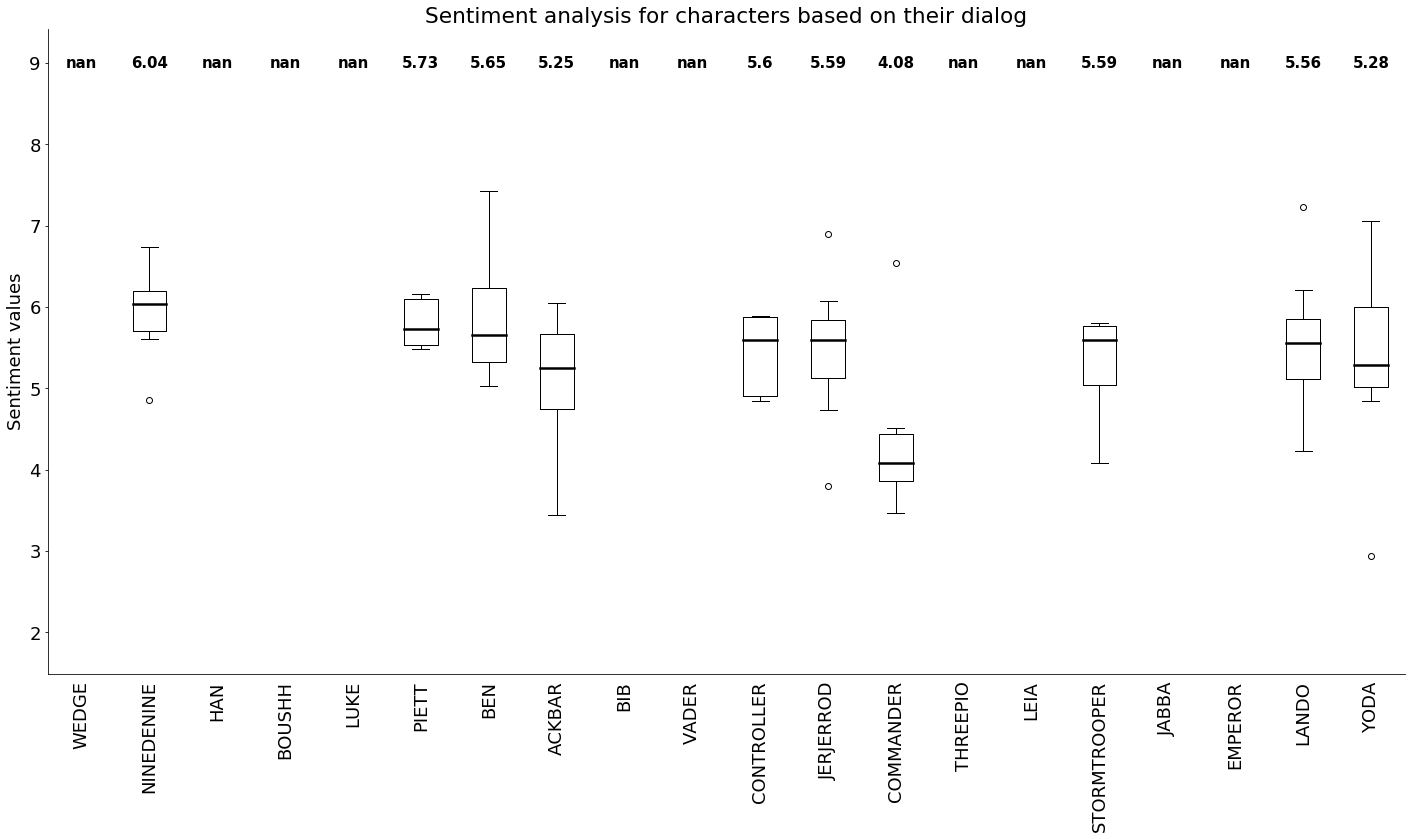

In [40]:
def characterSentimens(char_dict, name):
    fig, ax1 = plt.subplots(figsize=(20, 12))
    ax1.set_axisbelow(True)
    ax1.set_title("Sentiment analysis for characters based on their dialog")
    ax1.set_ylabel("Sentiment values")

    senti_dict = {}
    for char in char_dict.keys():
        d = getSentimentsForCharacter(char, char_dict)[1]
        if d and len(d) > 4:
            senti_dict[char] = d
    sorted_senti_dict = sorted(senti_dict.items(), key=lambda x: np.median(x[1]), reverse=True)
    
    top = 0
    bottom = 100
    data = [] 
    names = []
    for char in sorted_senti_dict:
        names.append(char[0])
        d = char[1]
        if top < max(d):
            top = max(d)
        if bottom > min(d):
            bottom = min(d)
        data.append(d)
    bp = ax1.boxplot(data)    
    
    ax1.set_xticklabels(names, rotation=90)
    
    plt.setp(bp['medians'], color="black")
    plt.setp(bp['medians'], linewidth=2.5)
        
    top = top + 1
    bottom = bottom - 0.25
    ax1.set_ylim(bottom, top)
    
    medians = [np.median(a) for a in data]
    pos = np.arange(len(names)) + 1
    upperLabels = [str(np.round(s, 2)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(len(names)), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
                 horizontalalignment='center', size='small', weight="bold",
                 color="black")
        
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)    
    plt.rcParams.update({'figure.autolayout': True})
    plt.savefig("docs/img/"+name+".png", transparent=True)

    plt.show()  
characterSentimens(character_dictIV, "sentiment_chars_iv")
characterSentimens(character_dictV, "sentiment_chars_v")
characterSentimens(character_dictVI, "sentiment_chars_vi")

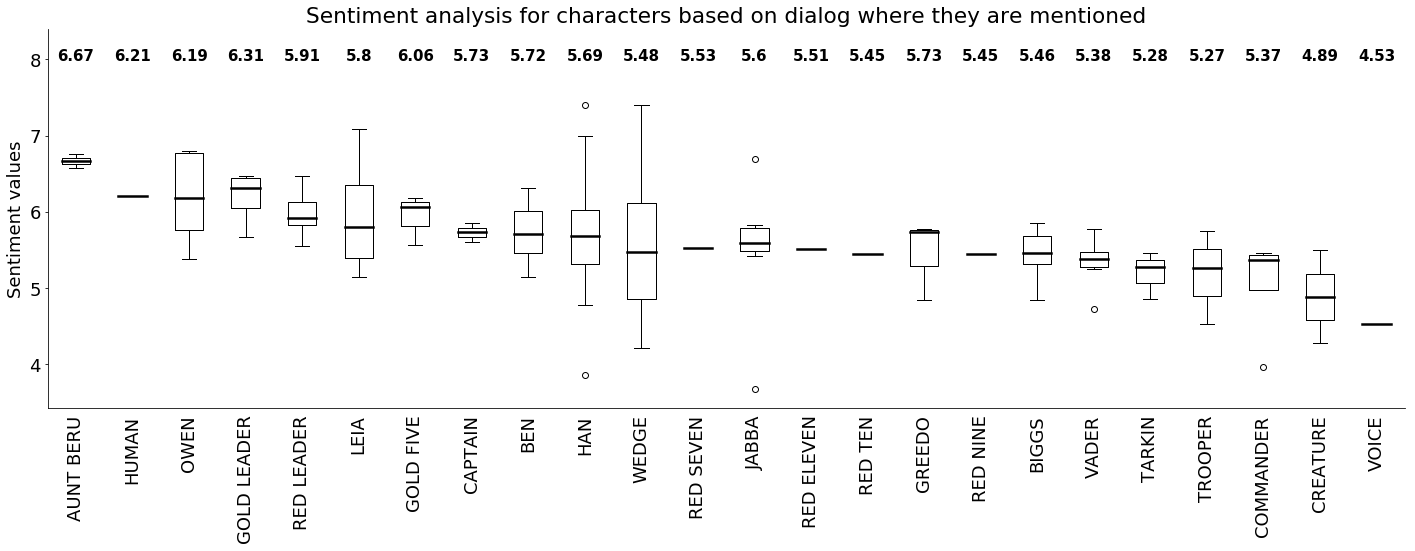

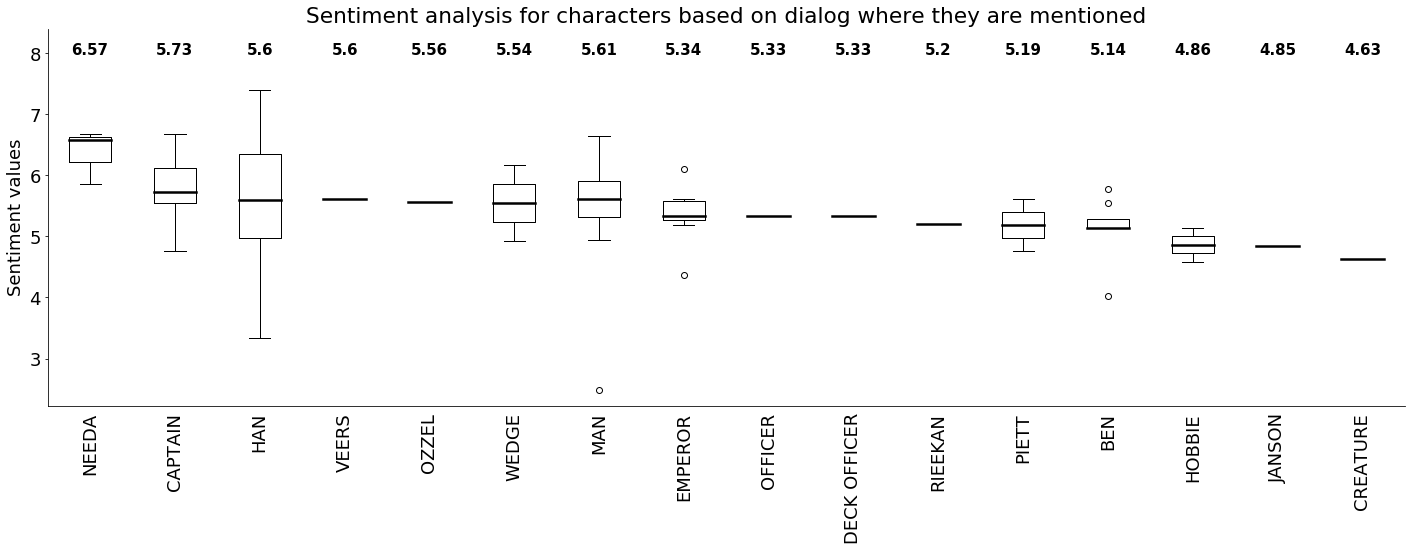

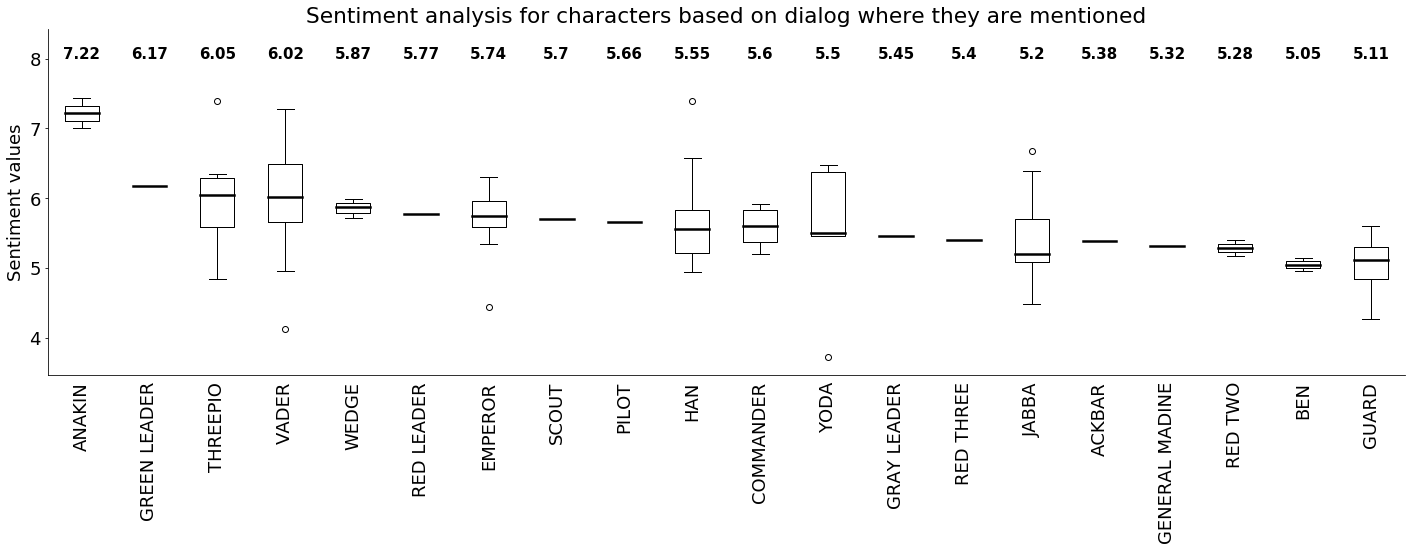

In [41]:
def getLinesContainingTerm(character_dict, term):
    lines = []
    for char in character_dict.keys():
        character = character_dict[char]
        for line in character:
            if term in line[2].lower():
                lines.append(line[2].lower())
    return lines

def getTermSentiment(character_dict, term):
    lines = getLinesContainingTerm(character_dict, term)
    sentiment = []
    if not lines:
        return 0, 0
    for line in lines:
        tokens = tokenize(line)
        senti = get_sentiment(tokens)
        if senti:
            sentiment.append(senti)
    return sentiment, np.mean(sentiment), np.std(sentiment)

def getNameSentiments(character_dict):
    sentiment_names = []
    for name in character_dict.keys():
        if name == "BERU":
            continue
        tupl = (name, getTermSentiment(character_dict, name.lower()))
        if tupl[1][1] > 0:
            sentiment_names.append(tupl)               
    sorted_sentiment_names = sorted (sentiment_names, key=lambda x: x[1][1], reverse=True)
    return sorted_sentiment_names

# Here we see what is said about the different persons, not what the persons themselves are saying.
def drawNameSentiments(character_dict, name):
    fig, ax1 = plt.subplots(figsize=(20, 8))
    ax1.set_axisbelow(True)
    ax1.set_title("Sentiment analysis for characters based on dialog where they are mentioned")
    ax1.set_ylabel("Sentiment values")
    
    top = 0
    bottom = 100
    data = [] 
    names = []
    
    dat = getNameSentiments(character_dict)
    for i in dat:
        data.append(i[1][0])
        names.append(i[0])
        if top < max(data[-1]):
            top = max(data[-1])
        if bottom > min(data[-1]):
            bottom = min(data[-1])
        
    bp = ax1.boxplot(data)
    plt.setp(bp['medians'], color="black")
    plt.setp(bp['medians'], linewidth=2.5)
        
    ax1.set_xticklabels(names, rotation=90)
    
    top = top + 1
    bottom = bottom - 0.25
    ax1.set_ylim(bottom, top)
    
    medians = [np.median(a) for a in data]
    pos = np.arange(len(names)) + 1
    upperLabels = [str(np.round(s, 2)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(len(names)), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
                 horizontalalignment='center', size='small', weight="bold",
                 color="black")
        
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)

    plt.rcParams.update({'figure.autolayout': True})
    plt.savefig("docs/img/"+name+".png", transparent=True)
    
    plt.show()
drawNameSentiments(character_dictIV, "sentiment_names_iv")
drawNameSentiments(character_dictV, "sentiment_names_v")
drawNameSentiments(character_dictVI, "sentiment_names_vi")

#### Discuss the outcome
We see that the sentiment of Darth Vader does become more positive throughout the series, one could say that it is possible to spot that he will be turning to the light by looking at the sentiment. We however believe that this is not shown solely by the sentiment as the sentiment can be positive even though you are evil (see namesentiments for the Emperor in movie 6, one of the most positive but still evil).

On the other hand, we are able to spot certain scenes only from the sentiments of the persons who are in this scene. This is shown in the plotting of sentiment for Leia, Luke and Han who in the first movie (Episode IV) gets trapped in a garbage compressor. This specific scene is shown on the plotting. It can be concluded that it is possible to find specific scenes from the sentiments only.

If we look at what the difference characters say, we quickly see that the sentiments of *A New Hope* is partly split, meaning that most of the heroes do have higher sentiment scores than that of their opponents. This trend is however destroyed by the *Return of the Jedi* where the emperor have the secondhighest sentiment. The sentiment of what the charachter says is not enough to tell if he is a hero of a villian. A funny observations comes from episode V, here *Yoda* is known as *Creature* until *Luke* realises who he is. From this we can see that *Yoda* is more positive before he starts training *Luke*. 
If we take a look at the sentiment for when people are mentioned the characters, we run in to similar issues, from episode V, we have Needa (An imperial Captain) as the most positive character, simply because everybody talks in a formal manner to the captains (even Vader). 
The sentiments alone has been found to sparse to provide a clear distinction between good and evil.

### Analysis step 3: The scripts
 
#### Explain what you're interested in
* Can we "see" the storyline from the sentiment of the scripts? 
* Is there a difference between the sentiment of the dialogue and the script?

 
#### Explain the tool
We will be utilizing the tools already described above in order to get a hold of the sentiments of the lines. The primary difference here will be that we apply the tools on a movie-level instead of characterlevel, meaning that we get the sentiments for the movies, accross all the characters. As we cannot clearly split the script into meaningful parts without a lot of manual labor, we will only have the mean of the movie sentiments.
 
 #### Apply the tool

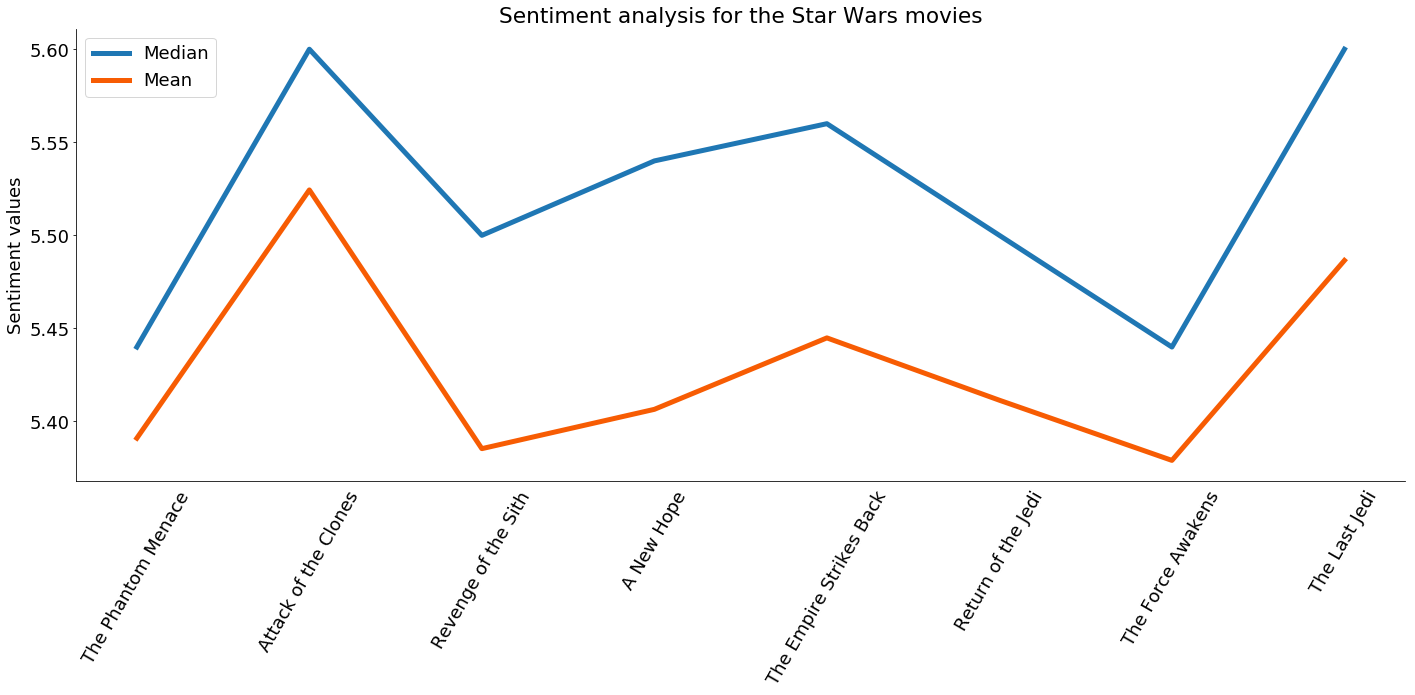

In [45]:
# Given a list of tokens it returns the mean and median of the 
def get_sentiments(tokens):
    sentiments = []
    for token in tokens:
        if token in sentiment_dict:
            sentiments.append(float(sentiment_dict[token])) # happiness avg
    return np.median(sentiments), np.mean(sentiments)

def getSentimentFromFile(filename):
    df = pd.read_fwf(filename)
    lst = df.iloc[:,0].tolist()
    lst_clean = [i for i in lst if not isinstance(i, float)]
    text = " ".join(lst_clean)
    tokens = tokenize(text)
    return get_sentiments(tokens)

def getMovieDatas():
    titles = ["./Scripts/The-Phantom-Menace.txt", "./Scripts/Attack-of-the-Clones.txt", "./Scripts/Revenge-of-the-Sith.txt", "./Scripts/A-New-Hope.txt", "./Scripts/The-Empire-Strikes-Back.txt", "./Scripts/Return-of-the-Jedi.txt", "./Scripts/The-Force-Awakens.txt", "./Scripts/The-Last-Jedi.txt"]
    return [getSentimentFromFile(i) for i in titles]

md = getMovieDatas()
median_movs = [i[0] for i in md]
mean_movs = [i[1] for i in md]

# plt.rcParams.update({'font.size': 16})
fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.set_axisbelow(True)
ax1.set_title("Sentiment analysis for the Star Wars movies")
ax1.set_ylabel("Sentiment values")

movie_names = ["HMMM2", "The Phantom Menace", "Attack of the Clones", "Revenge of the Sith", "A New Hope", "The Empire Strikes Back", "Return of the Jedi", "The Force Awakens", "The Last Jedi"]

ax1.plot(median_movs, label="Median", linewidth=5, color="#1f77b4")
ax1.plot(mean_movs, label="Mean", linewidth=5, color="#F75C03")

ax1.set_xticklabels(movie_names, rotation=60)

plt.legend()

i = 0
for spine in plt.gca().spines.values():
    if i % 2 == 1:
        spine.set_visible(False)
    i += 1
plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
   
plt.tight_layout()
plt.savefig("docs/img/sentiment_series.png", transparent=True)
plt.show()

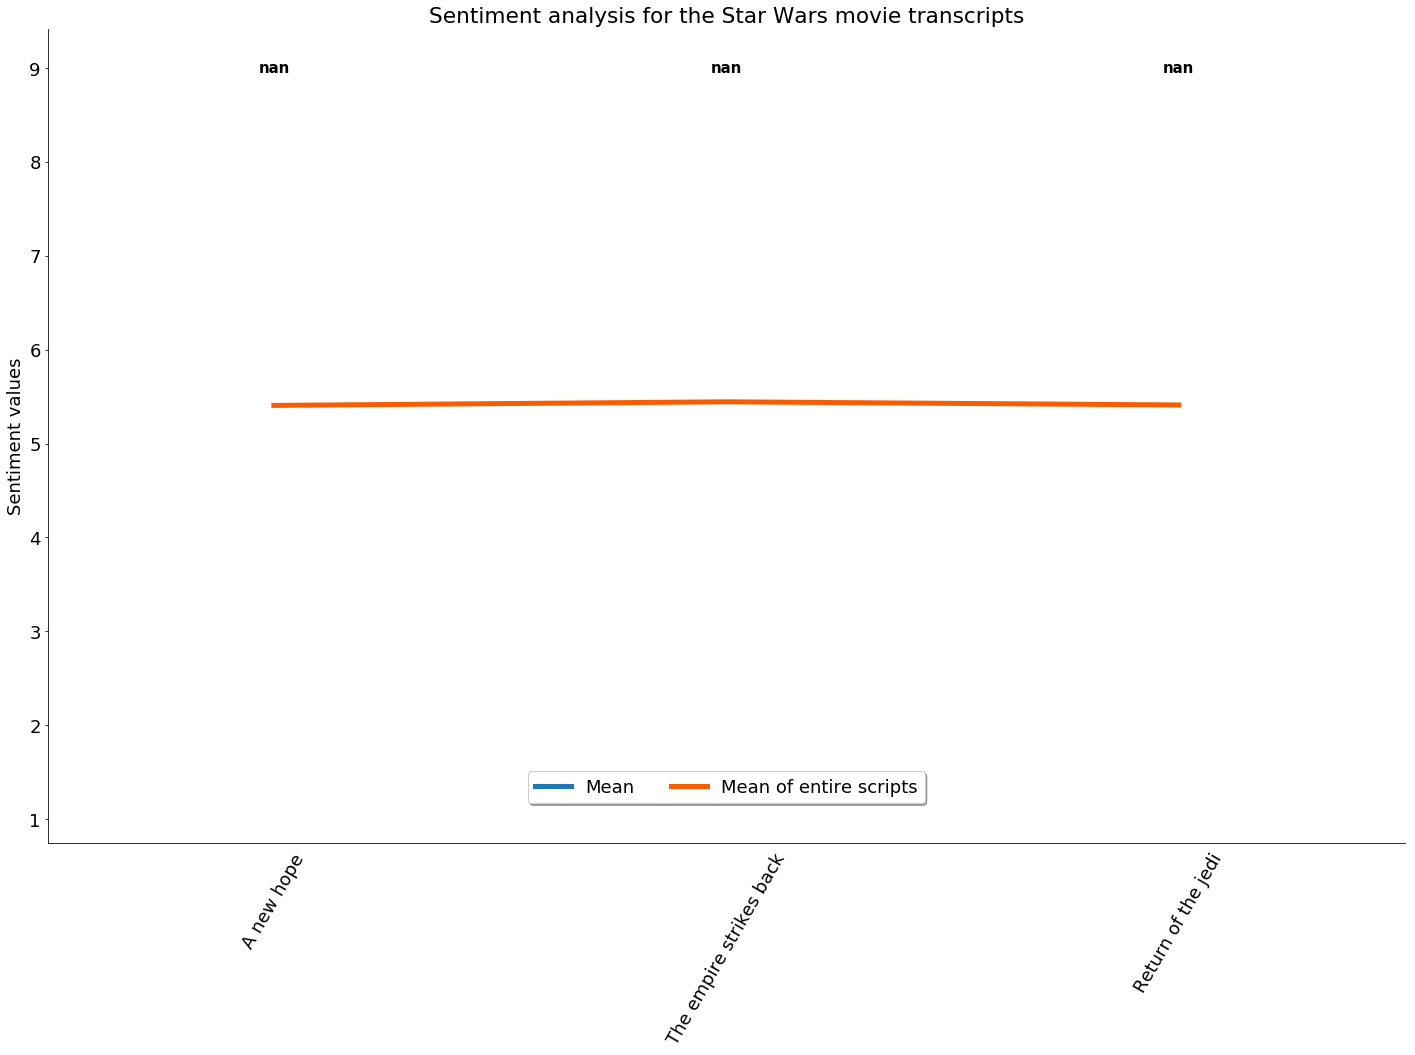

In [44]:
def getSentimentsForMovie(character_dict):
    sentiments = []
    for char in character_dict.keys():
        character = character_dict[char]
        for line in character:
            tokens = tokenize(line[2])
            sentiment = get_sentiment(tokens)
            if sentiment is None:
                continue
            sentiments.append(sentiment)
    return sentiments

def drawMovieSentiments(list_of_dicts, movie_names, name):
    fig, ax1 = plt.subplots(figsize=(20, 15))
    ax1.set_axisbelow(True)
    ax1.set_title("Sentiment analysis for the Star Wars movie transcripts")
    ax1.set_ylabel("Sentiment values")
    
    hmm = mean_movs[3:6]
    
    top = 0
    bottom = 100
    data = [] 
    for char_dict in list_of_dicts:
        d = getSentimentsForMovie(char_dict)
        if top < max(d):
            top = max(d)
        if bottom > min(d):
            bottom = min(d)
        data.append(d)
    bp = ax1.boxplot(data)
    ax1.set_xticklabels(movie_names, rotation=60)
    
    plt.setp(bp['medians'], color="black")
    plt.setp(bp['medians'], linewidth=2.5)
    
    top = top + 1
    bottom = bottom - 1
    ax1.set_ylim(bottom, top)
    
    medians = [np.median(a) for a in data]
    pos = np.arange(len(list_of_dicts)) + 1
    upperLabels = [str(np.round(s, 2)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(len(list_of_dicts)), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
                 horizontalalignment='center', size='small', weight="bold", color="black")
        
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    
    d1 = [i+1 for i in range(len(list_of_dicts))]
    d2 = [np.mean(a) for a in data]
    plt.plot(d1, d2, linewidth = 5, label = "Mean", color = "#1f77b4")  
    
    plt.plot(d1, hmm, linewidth=5, label="Mean of entire scripts", color="#F75C03")
    
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 0.1), fancybox=True, shadow=True, ncol=5)
    
    plt.rcParams.update({'figure.autolayout': True})
    plt.savefig("docs/img/"+name+".png", transparent=True)
    
    plt.show()  
drawMovieSentiments([character_dictIV, character_dictV, character_dictVI], ["A new hope", "The empire strikes back", "Return of the jedi"], "sentiment_across_movies")

#### Discuss the outcome
From the script sentiments we can se ups and downs throughout the series, however, they have another pattern that one would expect. We would expect episode VI to be a substantial high, ending the series on a highnote. This was however not the case when looking at the sentiments. The latest Star Wars movie however seem to be building up for the great finale, getting the our hopes up. 

Furthermore, we can see that the dialog and the script does fit very well together, with the script being marginally more negative than the dialog alone.


 ## Discussion 
 

    What went well?,
    What is still missing? What could be improved?, Why?
